In [1]:
'''
Data Manipulation
'''
import numpy as np
import pandas as pd

'''
Data Visualization
'''
import matplotlib.pyplot as plt
%matplotlib inline
# plt.figure(figsize=(10, 10))

import seaborn as sns
sns.set()

from plotly.offline import plot, iplot
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)

from yellowbrick.cluster import KElbowVisualizer

'''
Supress warnings
'''
import warnings
warnings.filterwarnings('ignore')

'''
Modeling
'''
# K-Means
from sklearn.cluster import KMeans
# Hierarchical
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering
# PCA
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier

'''
Data Preprocessing
'''
from sklearn.preprocessing import scale
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

'''
Null value Inputer
'''
# from sklearn.base import TransformerMixin

'''
Classification Metrics
'''
from sklearn.metrics import auc, \
                            confusion_matrix, \
                            classification_report, \
                            roc_curve, \
                            roc_auc_score, \
                            precision_recall_curve, \
                            average_precision_score, \
                            accuracy_score, \
                            balanced_accuracy_score, \
                            precision_score, \
                            recall_score, \
                            cohen_kappa_score, \
                            f1_score
'''
Model Selection
'''
from sklearn.model_selection import train_test_split, \
                                    KFold, \
                                    cross_val_score

# Used Functions

In [2]:
def heatmap(x, y, **kwargs):
    '''
    Helper function, will not be used imidiatly
    '''
    
    if 'color' in kwargs:
        color = kwargs['color']
    else:
        color = [1]*len(x)

    if 'palette' in kwargs:
        palette = kwargs['palette']
        n_colors = len(palette)
    else:
        n_colors = 256 # Use 256 colors for the diverging color palette
        palette = sns.color_palette("Blues", n_colors) 

    if 'color_range' in kwargs:
        color_min, color_max = kwargs['color_range']
    else:
        color_min, color_max = min(color), max(color) # Range of values that will be mapped to the palette, i.e. min and max possible correlation

    def value_to_color(val):
        if color_min == color_max:
            return palette[-1]
        else:
            val_position = float((val - color_min)) / (color_max - color_min) # position of value in the input range, relative to the length of the input range
            val_position = min(max(val_position, 0), 1) # bound the position betwen 0 and 1
            ind = int(val_position * (n_colors - 1)) # target index in the color palette
            return palette[ind]

    if 'size' in kwargs:
        size = kwargs['size']
    else:
        size = [1]*len(x)

    if 'size_range' in kwargs:
        size_min, size_max = kwargs['size_range'][0], kwargs['size_range'][1]
    else:
        size_min, size_max = min(size), max(size)

    size_scale = kwargs.get('size_scale', 500)

    def value_to_size(val):
        if size_min == size_max:
            return 1 * size_scale
        else:
            val_position = (val - size_min) * 0.99 / (size_max - size_min) + 0.01 # position of value in the input range, relative to the length of the input range
            val_position = min(max(val_position, 0), 1) # bound the position betwen 0 and 1
            return val_position * size_scale
    if 'x_order' in kwargs: 
        x_names = [t for t in kwargs['x_order']]
    else:
        x_names = [t for t in sorted(set([v for v in x]))]
    x_to_num = {p[1]:p[0] for p in enumerate(x_names)}

    if 'y_order' in kwargs: 
        y_names = [t for t in kwargs['y_order']]
    else:
        y_names = [t for t in sorted(set([v for v in y]))]
    y_to_num = {p[1]:p[0] for p in enumerate(y_names)}

    plot_grid = plt.GridSpec(1, 15, hspace=0.2, wspace=0.1) # Setup a 1x10 grid
    ax = plt.subplot(plot_grid[:,:-1]) # Use the left 14/15ths of the grid for the main plot

    marker = kwargs.get('marker', 's')

    kwargs_pass_on = {k:v for k,v in kwargs.items() if k not in [
         'color', 'palette', 'color_range', 'size', 'size_range', 'size_scale', 'marker', 'x_order', 'y_order'
    ]}

    ax.scatter(
        x=[x_to_num[v] for v in x],
        y=[y_to_num[v] for v in y],
        marker=marker,
        s=[value_to_size(v) for v in size], 
        c=[value_to_color(v) for v in color],
        **kwargs_pass_on
    )
    ax.set_xticks([v for k,v in x_to_num.items()])
    ax.set_xticklabels([k for k in x_to_num], rotation=45, horizontalalignment='right')
    ax.set_yticks([v for k,v in y_to_num.items()])
    ax.set_yticklabels([k for k in y_to_num])

    ax.grid(False, 'major')
    ax.grid(True, 'minor')
    ax.set_xticks([t + 0.5 for t in ax.get_xticks()], minor=True)
    ax.set_yticks([t + 0.5 for t in ax.get_yticks()], minor=True)

    ax.set_xlim([-0.5, max([v for v in x_to_num.values()]) + 0.5])
    ax.set_ylim([-0.5, max([v for v in y_to_num.values()]) + 0.5])
    ax.set_facecolor('#F1F1F1')

    # Add color legend on the right side of the plot
    if color_min < color_max:
        ax = plt.subplot(plot_grid[:,-1]) # Use the rightmost column of the plot

        col_x = [0]*len(palette) # Fixed x coordinate for the bars
        bar_y=np.linspace(color_min, color_max, n_colors) # y coordinates for each of the n_colors bars

        bar_height = bar_y[1] - bar_y[0]
        ax.barh(
            y=bar_y,
            width=[5]*len(palette), # Make bars 5 units wide
            left=col_x, # Make bars start at 0
            height=bar_height,
            color=palette,
            linewidth=0
        )
        ax.set_xlim(1, 2) # Bars are going from 0 to 5, so lets crop the plot somewhere in the middle
        ax.grid(False) # Hide grid
        ax.set_facecolor('white') # Make background white
        ax.set_xticks([]) # Remove horizontal ticks
        ax.set_yticks(np.linspace(min(bar_y), max(bar_y), 3)) # Show vertical ticks for min, middle and max
        ax.yaxis.tick_right() # Show vertical ticks on the right 


def corrplot(data, size_scale=500, marker='s'):
    '''
    In addition to color (in standard correlation matrix plot), 
    I’ve added size as a parameter to our heatmap. 
    The size of each square corresponds to the magnitude of the correlation it represents.
    
    Parameters
    data (matrix): correlation matrix of initial dataframe
    
    Return:
    More informative correlation matrix    
    '''
    
    corr = pd.melt(data.reset_index(), id_vars='index')
    corr.columns = ['x', 'y', 'value']
    heatmap(
        corr['x'], corr['y'],
        color=corr['value'], color_range=[-1, 1],
        palette=sns.diverging_palette(20, 220, n=256),
        size=corr['value'].abs(), size_range=[0,1],
        marker=marker,
        x_order=data.columns,
        y_order=data.columns[::-1],
        size_scale=size_scale
    )
# corr = df.corr()
# plt.figure(figsize=(10, 10))
# corrplot(corr)

In [3]:
def classificationReport(y_actual, y_pred):
    cnf_matrix = confusion_matrix(y_actual, y_pred)

    FP = cnf_matrix.sum(axis=0) - np.diag(cnf_matrix)
    FN = cnf_matrix.sum(axis=1) - np.diag(cnf_matrix)
    TP = np.diag(cnf_matrix)
    TN = cnf_matrix.sum() - (FP + FN + TP)

    FP = FP.astype(float)
    FN = FN.astype(float)
    TP = TP.astype(float)
    TN = TN.astype(float)

    # Sensitivity, hit rate, recall, or true positive rate
    TPR = TP/(TP+FN)
    # Specificity or true negative rate
    TNR = TN/(TN+FP) 
    # Precision or positive predictive value
    PPV = TP/(TP+FP)
    # Negative predictive value
    NPV = TN/(TN+FN)
    # Fall out or false positive rate
    FPR = FP/(FP+TN)
    # False negative rate
    FNR = FN/(TP+FN)
    # False discovery rate
    FDR = FP/(TP+FP)
    # Overall accuracy
    ACC = (TP+TN)/(TP+FP+FN+TN)

    print('TPR: {}'.format(TPR))
    print('TNR: {}'.format(TNR))
    print('PPV: {}'.format(PPV))
    print('NPV: {}'.format(NPV))
    print('FPR: {}'.format(FPR))
    print('FNR: {}'.format(FNR))
    print('FDR: {}'.format(FDR))
    print('ACC(Overall accuracy): {}'.format(ACC))

# Load the data

In [4]:
df = pd.read_csv("Input/Wine.csv")

In [5]:
df.head()

,Type,Alcohol,Malic,Ash,Alcalinity,Magnesium,Phenols,Flavanoids,Nonflavanoids,Proanthocyanins,Color,Hue,Dilution,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 14 columns):
Type               178 non-null int64
Alcohol            178 non-null float64
Malic              178 non-null float64
Ash                178 non-null float64
Alcalinity         178 non-null float64
Magnesium          178 non-null int64
Phenols            178 non-null float64
Flavanoids         178 non-null float64
Nonflavanoids      178 non-null float64
Proanthocyanins    178 non-null float64
Color              178 non-null float64
Hue                178 non-null float64
Dilution           178 non-null float64
Proline            178 non-null int64
dtypes: float64(11), int64(3)
memory usage: 19.5 KB


In [7]:
'''
Separate features and label from the original german dataset
'''
X = df.drop(columns=['Type'])
y = df['Type']

# K-NN 

In [8]:
'''
Find the optimal value of the parameter k for knn
'''
K = np.arange(1,25)

scores = []

for k in K:
    knn = KNeighborsClassifier(n_neighbors=k)
    
    kfold = KFold(n_splits=10)
    
    score = cross_val_score(knn, X, y, cv = kfold, scoring = "accuracy")
    
    scores.append(score)

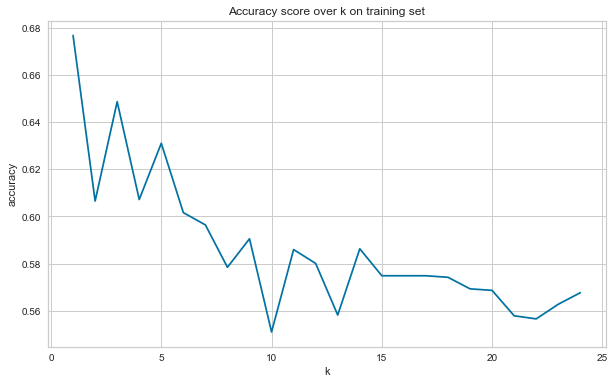

In [9]:
'''
Plot accuracy over various k to find the optimal one.
'''
plt.figure(figsize = (10,6))

plt.plot(K, np.mean(np.array(scores), axis = 1))

plt.title('Accuracy score over k on training set')

plt.xlabel('k')

plt.ylabel('accuracy')

plt.show()

In [10]:
'''
Fit the best model
'''
optimal_k = np.argmax(np.mean(scores, axis=1)) + 1

optimal_knn = KNeighborsClassifier(n_neighbors = optimal_k)
optimal_knn.fit(X,y)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=1, p=2,
           weights='uniform')

In [11]:
'''
Measures wich will be used on confusion matrix and roc-curve calculation
'''
y_pred = optimal_knn.predict(X)
y_pred_prob = optimal_knn.predict_proba(X)

print(classificationReport(y, y_pred))
print('\n')
print('sklearn approach')
print('\n')
print(classification_report(y, y_pred))

TPR: [1. 1. 1.]
TNR: [1. 1. 1.]
PPV: [1. 1. 1.]
NPV: [1. 1. 1.]
FPR: [0. 0. 0.]
FNR: [0. 0. 0.]
FDR: [0. 0. 0.]
ACC(Overall accuracy): [1. 1. 1.]
None


sklearn approach


              precision    recall  f1-score   support

           1       1.00      1.00      1.00        59
           2       1.00      1.00      1.00        71
           3       1.00      1.00      1.00        48

   micro avg       1.00      1.00      1.00       178
   macro avg       1.00      1.00      1.00       178
weighted avg       1.00      1.00      1.00       178



# PCA

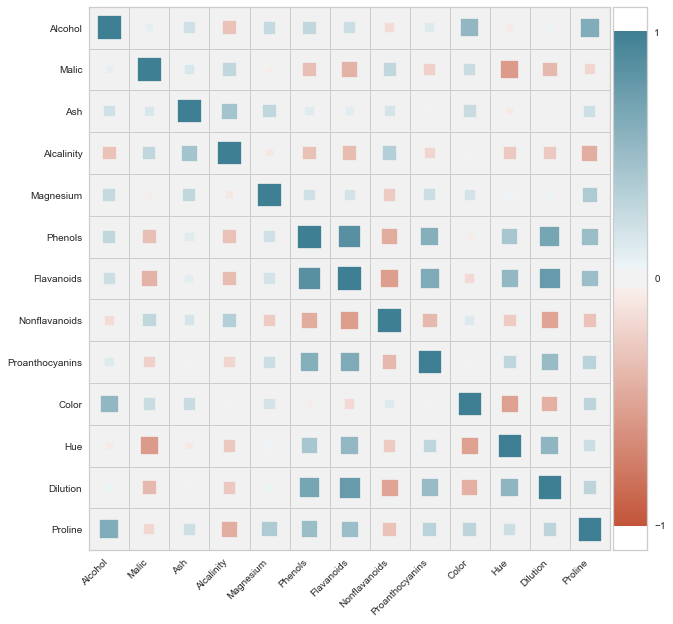

In [12]:
corr = X.corr()
plt.figure(figsize=(10, 10))
corrplot(corr)

According to above plotted correlation matrix we can say, that there is kind of good relationship between features, so PCA will work good in this case and most probably will find small number of features explain overall dataset

In [13]:
X = pd.DataFrame(scale(X), index = X.index, columns = X.columns)
# X.head(2)

In [14]:
pca = PCA(.80)
pca.fit(X)
# pca.n_components_
x = pca.transform(X)

In [15]:
'''
Find the optimal value of the parameter k for knn
'''
K = np.arange(1,25)

scores = []

for k in K:
    knn = KNeighborsClassifier(n_neighbors=k)
    
    kfold = KFold(n_splits=10)
    
    score = cross_val_score(knn, x, y, cv = kfold, scoring = "accuracy")
    
    scores.append(score)

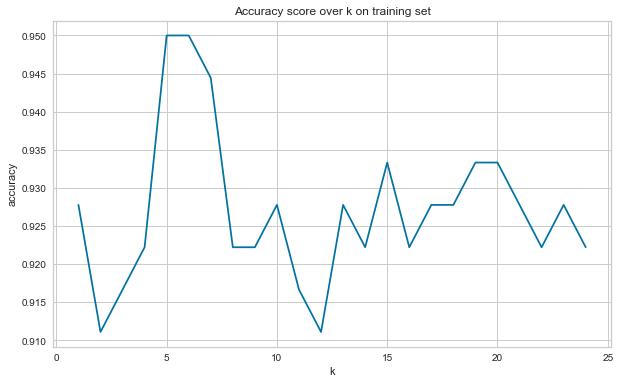

In [16]:
'''
Plot accuracy over various k to find the optimal one.
'''
plt.figure(figsize = (10,6))

plt.plot(K, np.mean(np.array(scores), axis = 1))

plt.title('Accuracy score over k on training set')

plt.xlabel('k')

plt.ylabel('accuracy')

plt.show()

In [17]:
'''
Fit the best model
'''
optimal_k = np.argmax(np.mean(scores, axis=1)) + 1

optimal_knn = KNeighborsClassifier(n_neighbors = optimal_k)
optimal_knn.fit(x,y)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')

In [18]:
'''
Measures wich will be used on confusion matrix and roc-curve calculation
'''
y_pred = optimal_knn.predict(x)
y_pred_prob = optimal_knn.predict_proba(x)

print(classificationReport(y, y_pred))
print('\n')
print('sklearn approach')
print('\n')
print(classification_report(y, y_pred))

TPR: [1.         0.95774648 1.        ]
TNR: [0.99159664 1.         0.98461538]
PPV: [0.98333333 1.         0.96      ]
NPV: [1.         0.97272727 1.        ]
FPR: [0.00840336 0.         0.01538462]
FNR: [0.         0.04225352 0.        ]
FDR: [0.01666667 0.         0.04      ]
ACC(Overall accuracy): [0.99438202 0.98314607 0.98876404]
None


sklearn approach


              precision    recall  f1-score   support

           1       0.98      1.00      0.99        59
           2       1.00      0.96      0.98        71
           3       0.96      1.00      0.98        48

   micro avg       0.98      0.98      0.98       178
   macro avg       0.98      0.99      0.98       178
weighted avg       0.98      0.98      0.98       178



Results with and without PCA are a little bit differente, because as we see, without pca, for example overall accuracy is exactly equal to 1 for each class, but with pca, this measure is equal to 0.99438202  for 1st class, 0.98314607  for 2nd class, and 0.98876404 for 3th class, so the result is not as good as it was in without pca case, but it is good prediction as well

# K-Means

In [19]:
'''
Separate features and label from the original german dataset
'''
X = df.drop(columns=['Type'])
y = df['Type']

In [20]:
# I've already deleted the type column in X dataset, so it is what we want
X.head()

,Alcohol,Malic,Ash,Alcalinity,Magnesium,Phenols,Flavanoids,Nonflavanoids,Proanthocyanins,Color,Hue,Dilution,Proline
0,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [21]:
labels = KMeans(n_clusters = 3, random_state = 0).fit_predict(X)

In [22]:
X['predicted'] = labels
X['target'] = y

In [23]:
X.head(2)

,Alcohol,Malic,Ash,Alcalinity,Magnesium,Phenols,Flavanoids,Nonflavanoids,Proanthocyanins,Color,Hue,Dilution,Proline,predicted,target
0,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065,1,1
1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050,1,1


In [24]:
X['majority_vote'] = None

for i in range(3):
    assign = np.argmax(y[X.index[X.predicted == i]].value_counts())
    X['majority_vote'].iloc[list(X.index[X.predicted == i])] = assign

In [25]:
print(classificationReport(X.target, X.majority_vote))
print('\n')
print('sklearn approach')
print('\n')
print(classification_report(X.target, X.majority_vote))

TPR: [0.77966102 0.70422535 0.60416667]
TNR: [0.99159664 0.82242991 0.74615385]
PPV: [0.9787234  0.72463768 0.46774194]
NPV: [0.90076336 0.80733945 0.8362069 ]
FPR: [0.00840336 0.17757009 0.25384615]
FNR: [0.22033898 0.29577465 0.39583333]
FDR: [0.0212766  0.27536232 0.53225806]
ACC(Overall accuracy): [0.92134831 0.7752809  0.70786517]
None


sklearn approach


              precision    recall  f1-score   support

           1       0.98      0.78      0.87        59
           2       0.72      0.70      0.71        71
           3       0.47      0.60      0.53        48

   micro avg       0.70      0.70      0.70       178
   macro avg       0.72      0.70      0.70       178
weighted avg       0.74      0.70      0.71       178



Oviously firt method was the better, because we have labels and here(in kmeans) we didn't use them, and the above printed result shows that, 

In [26]:
X.drop(columns=['predicted', 'target', 'majority_vote'], inplace=True)

In [27]:
X.head(2)

,Alcohol,Malic,Ash,Alcalinity,Magnesium,Phenols,Flavanoids,Nonflavanoids,Proanthocyanins,Color,Hue,Dilution,Proline
0,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050


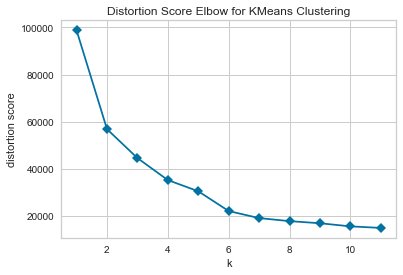

In [28]:
# Instantiate the clustering model and visualizer
model = KMeans()
visualizer = KElbowVisualizer(
    model, k=(1,12), metric='distortion', timings=False
)

visualizer.fit(X)    # Fit the data to the visualizer
visualizer.poof()    # Draw/show/poof the data

In [29]:
# '''
# Separate features and label from the original german dataset
# '''
# X = df.drop(columns=['Type'])
# y = df['Type']

In [30]:
labels = KMeans(n_clusters = 6, random_state = 0).fit_predict(X)

X['predicted'] = labels
X['target'] = y


X['majority_vote'] = None

for i in range(6):
    assign = np.argmax(y[X.index[X.predicted == i]].value_counts())
    X['majority_vote'].iloc[list(X.index[X.predicted == i])] = assign


In [31]:
X.majority_vote.unique()

array([1, 3, 2], dtype=int64)

In [32]:
X.predicted.unique()

array([0, 5, 3, 4, 2, 1], dtype=int64)

In [33]:
print(classificationReport(X.target, X.majority_vote))
print('\n')
print('sklearn approach')
print('\n')
print(classification_report(X.target, X.majority_vote))

TPR: [0.98305085 0.63380282 0.5625    ]
TNR: [0.87394958 0.88785047 0.83846154]
PPV: [0.79452055 0.78947368 0.5625    ]
NPV: [0.99047619 0.78512397 0.83846154]
FPR: [0.12605042 0.11214953 0.16153846]
FNR: [0.01694915 0.36619718 0.4375    ]
FDR: [0.20547945 0.21052632 0.4375    ]
ACC(Overall accuracy): [0.91011236 0.78651685 0.76404494]
None


sklearn approach


              precision    recall  f1-score   support

           1       0.79      0.98      0.88        59
           2       0.79      0.63      0.70        71
           3       0.56      0.56      0.56        48

   micro avg       0.73      0.73      0.73       178
   macro avg       0.72      0.73      0.71       178
weighted avg       0.73      0.73      0.72       178



The result is almost the same as in k = 3 case , because we notice, that number of unique clusters after majority vote is equal to 3 and the left clusters has only a few objects in it